In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import statsmodels.api as sm

from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

from dateutil.relativedelta import relativedelta

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
#pd.reset_option('display.float_format')

In [56]:
data = pd.read_csv("./data/kc_house_data.csv")

# Misc Functions

In [57]:

def checkForColinearity(df_ColsToCheck):
    df=df_ColsToCheck.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    #zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    #set index to pairs
    df.set_index(['pairs'], inplace = True)

    #drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    #rename correlation column as cc rather than 0
    df.columns = ['cc']

    #drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    df.drop_duplicates(inplace=True)
    df = df[(df.cc>.70) & (df.cc <1)]
    return df

def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(60,30))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)

def checkForVIF(df_ColsToCheck):
#     X = df[x_cols]
    vif = [variance_inflation_factor(df_ColsToCheck.values, i) for i in range(df_ColsToCheck.shape[1])]
    vifresults = list(zip(df_ColsToCheck.columns, vif))
    return vifresults

def scaleData_min_max (df_continuous):
    scaler = MinMaxScaler()
    # transform data
    scaler_a = MinMaxScaler().fit(df_continuous)
    scaler_ = scaler.fit_transform(df_continuous)
    scaled_df = pd.DataFrame(scaler_, columns=df_continuous.columns)
    scaled_df_no_index = scaled_df.reset_index(drop=True)
    #
    return scaled_df_no_index, scaler_a

# Preprocessing

Ensure No Missing Values

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


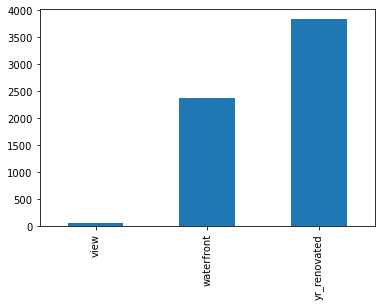

In [58]:
missing = data.isnull().sum()
missing = missing[missing > 0]
print (missing)
missing.sort_values(inplace=True)
missing.plot.bar();

In [59]:
#fill In Waterfront and View Nulls
data_No_NAs = data
data_No_NAs['waterfront'].fillna(data['waterfront'].mode()[0], inplace=True)
data_No_NAs['view'].fillna(data['view'].mode()[0], inplace=True)


#fill In Year Renovated and insert "Age of Home" (Today - Year Built) and "Years Since Renovated"
data_No_NAs["yr_renovated"].fillna(0, inplace=True)
data_No_NAs["yr_renovated"]  = data_No_NAs.apply(lambda row : (row['yr_built']) if row["yr_renovated"] == 0 else row["yr_renovated"], axis=1)
# data_No_NAs["YearsSinceRenovation"] = data_No_NAs.apply(lambda row : (2020 - row['yr_renovated']) if row["yr_renovated"] != 0 else (2020 - row["yr_built"]), axis=1)
data_No_NAs["AgeOfHome"] = (2020 - data_No_NAs["yr_built"])

#handle "?" in the sqrt basement column
data_No_NAs["sqft_basement"]  = data_No_NAs.apply(lambda row : 0 if row["sqft_basement"] == "?" else row["sqft_basement"], axis=1)
data_No_NAs["sqft_basement"] = data_No_NAs["sqft_basement"].astype('float')

data_No_NAs["zipcode_str"] = data_No_NAs["zipcode"].astype('str')
data_No_NAs['ZipFirst3'] = data_No_NAs["zipcode_str"].str[:3]
data_No_NAs = data_No_NAs.drop("zipcode_str", axis=1) 

data_No_NAs['salesyear'] = pd.DatetimeIndex(data_No_NAs['date']).year
data_No_NAs['sls_month'] = pd.DatetimeIndex(data_No_NAs['date']).month

In [60]:
df_check2 = data_No_NAs.loc[data_No_NAs.waterfront ==1]
len(df_check2)

146

In [61]:
data_No_NAs.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3,salesyear,sls_month
0,7129300520,10/13/2014,"221,900",3,1,1180,5650,1,0,0,3,7,1180,0,1955,"1,955",98178,48,-122,1340,5650,65,981,2014,10
1,6414100192,12/9/2014,"538,000",3,2,2570,7242,2,0,0,3,7,2170,400,1951,"1,991",98125,48,-122,1690,7639,69,981,2014,12
2,5631500400,2/25/2015,"180,000",2,1,770,10000,1,0,0,3,6,770,0,1933,"1,933",98028,48,-122,2720,8062,87,980,2015,2
3,2487200875,12/9/2014,"604,000",4,3,1960,5000,1,0,0,5,7,1050,910,1965,"1,965",98136,48,-122,1360,5000,55,981,2014,12
4,1954400510,2/18/2015,"510,000",3,2,1680,8080,1,0,0,3,8,1680,0,1987,"1,987",98074,48,-122,1800,7503,33,980,2015,2


In [62]:
df_check2 = data_No_NAs.loc[data_No_NAs.id ==8732030490]
df_check2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3,salesyear,sls_month
4252,8732030490,12/22/2014,"261,500",4,2,2460,7800,1,0,0,3,8,1500,960,1977,"1,977",98023,47,-122,2210,7800,43,980,2014,12


In [63]:
missing = data.isnull().sum()
missing

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
AgeOfHome        0
zipcode_str      0
ZipFirst3        0
dtype: int64

# <u> <font color='red'>Model 1 Dataset</font></u>

##    A. "Finding" Target Market

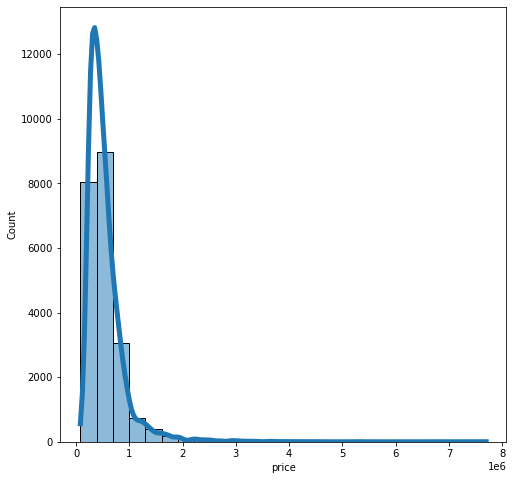

In [64]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=data_No_NAs,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

Majority of Homes Priced <$1,000,000

Establish Target Market --> Price Range That Contains Most Data Points 

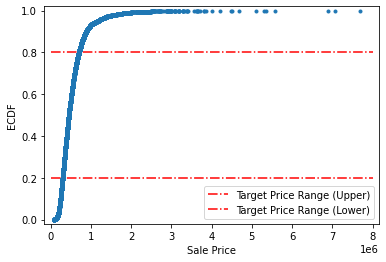

In [65]:
x = np.sort(data_No_NAs['price'])
y = np.arange(1, len(x)+1)/ len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.hlines(.8, 0, 8000000, colors='red', linestyles='dashdot', label='Target Price Range (Upper)', data=None)
_ = plt.hlines(.2, 0, 8000000, colors='red', linestyles='dashdot', label='Target Price Range (Lower)', data=None)
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Sale Price')
plt.legend(loc="lower right")
plt.margins(.02) # keeps data from running off edge
plt.show()

In [66]:
pd.options.display.float_format = '{:,.0f}'.format
data_No_NAs.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,salesyear,sls_month
count,"21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597"
mean,"4,580,474,288","540,297",3,2,"2,080","15,099",1,0,0,3,8,"1,789",286,"1,971","1,973","98,078",48,-122,"1,987","12,758",49,"2,014",7
std,"2,876,735,716","367,368",1,1,918,"41,413",1,0,1,1,1,828,440,29,29,54,0,0,685,"27,274",29,0,3
min,"1,000,102","78,000",1,0,370,520,1,0,0,1,3,370,0,"1,900","1,900","98,001",47,-123,399,651,5,"2,014",1
25%,"2,123,049,175","322,000",3,2,"1,430","5,040",1,0,0,3,7,"1,190",0,"1,951","1,954","98,033",47,-122,"1,490","5,100",23,"2,014",4
50%,"3,904,930,410","450,000",3,2,"1,910","7,618",2,0,0,3,7,"1,560",0,"1,975","1,977","98,065",48,-122,"1,840","7,620",45,"2,014",6
75%,"7,308,900,490","645,000",4,2,"2,550","10,685",2,0,0,4,8,"2,210",550,"1,997","1,999","98,118",48,-122,"2,360","10,083",69,"2,015",9
max,"9,900,000,190","7,700,000",33,8,"13,540","1,651,359",4,1,4,5,13,"9,410","4,820","2,015","2,015","98,199",48,-121,"6,210","871,200",120,"2,015",12


50% Data Points Between $800,000 - and $250,000, Remove Outliers on both sides and rerun, currently mean and standard deviation impacted significantly by large home values

In [67]:
lower = 250000
upper = 800000
log_lower = np.log(lower)
log_upper = np.log(upper)

data_No_NAs["log_price"] = np.log(data_No_NAs['price'])

# q_high = data_No_NAs['log_price'].quantile(.85)
# q_low = data_No_NAs['log_price'].quantile(.25)

q_high = log_upper
q_low = log_lower

data_Target_Homes = data_No_NAs[data_No_NAs['log_price']<q_high]
data_Target_Homes = data_Target_Homes[data_Target_Homes['log_price']>q_low]
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,salesyear,sls_month,log_price
count,"16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170"
mean,"4,647,897,508","467,108",3,2,"1,960","14,321",1,0,0,3,8,"1,688",266,"1,972","1,974","98,079",48,-122,"1,911","12,335",48,"2,014",7,13
std,"2,874,291,078","144,243",1,1,680,"38,328",1,0,1,1,1,659,398,29,29,51,0,0,545,"26,144",29,0,3,0
min,"1,000,102","250,200",1,0,370,520,1,0,0,1,3,370,0,"1,900","1,900","98,001",47,-123,399,651,5,"2,014",1,12
25%,"2,206,700,094","345,000",3,2,"1,460","4,895",1,0,0,3,7,"1,200",0,"1,952","1,954","98,034",47,-122,"1,500","5,000",22,"2,014",4,13
50%,"3,982,700,188","445,000",3,2,"1,880","7,337",2,0,0,3,7,"1,530",0,"1,977","1,978","98,072",48,-122,"1,820","7,406",43,"2,014",6,13
75%,"7,349,615,080","570,000",4,2,"2,390","10,140",2,0,0,4,8,"2,080",520,"1,998","1,999","98,118",48,-122,"2,250","9,736",68,"2,015",9,13
max,"9,900,000,190","799,990",33,8,"5,820","1,651,359",4,1,4,5,11,"5,450","2,196","2,015","2,015","98,199",48,-121,"4,670","560,617",120,"2,015",12,14


In [68]:
np.exp(q_high)

800000.0000000003

Mean now closer to 50%

Remove additional outliers Ex. bedrooms = 33 , Bathrooms < 8, Sqft_Lot <12000. > 4000, Homes that have sold more than 1 on target years

In [69]:
# data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['bedrooms'] < (7)] # > 10 Bedrooms
# data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['bathrooms'] < (6)]  # > 6 Bathrooms
data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['bathrooms'] >= 1]  # > 6 Bathrooms
data_Target_Homes = data_Target_Homes.loc[(4000 <= data_Target_Homes['sqft_lot']) & (data_Target_Homes['sqft_lot'] <= 12000)] #4000, 12000
data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['AgeOfHome'] < 50]
data_Target_Homes = data_Target_Homes.loc[(data_Target_Homes['sqft_basement'] >100) | (data_Target_Homes['waterfront']==1)]

In [70]:
df_check2 = data_Target_Homes.loc[data_Target_Homes.waterfront ==1]
len(df_check2)

1

In [71]:
df_check2 = data_Target_Homes.loc[data_Target_Homes.waterfront ==1]
df_check2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3,salesyear,sls_month,log_price
16556,2923039243,11/13/2014,"340,000",4,1,1200,11834,1,1,3,3,6,1200,0,1972,"1,972",98070,47,-122,1670,47462,48,980,2014,11,13


In [72]:
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,salesyear,sls_month,log_price
count,"1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410","1,410"
mean,"4,928,127,022","457,895",4,2,"2,245","8,055",1,0,0,3,8,"1,522",723,"1,984","1,984","98,063",48,-122,"2,033","8,272",36,"2,014",7,13
std,"2,858,022,630","144,636",1,1,632,"1,865",0,0,1,1,1,490,298,11,11,50,0,0,476,"2,489",11,0,3,0
min,"11,300,120","250,600",1,1,"1,090","4,000",1,0,0,2,6,590,0,"1,971","1,971","98,001",47,-122,930,"1,499",5,"2,014",1,12
25%,"2,473,410,442","330,000",3,2,"1,790","7,034",1,0,0,3,7,"1,210",500,"1,977","1,977","98,030",47,-122,"1,720","7,228",31,"2,014",4,13
50%,"4,099,550,150","440,000",4,2,"2,120","7,930",1,0,0,3,8,"1,380",690,"1,979","1,979","98,052",48,-122,"1,960","8,024",41,"2,014",6,13
75%,"7,696,115,125","555,000",4,3,"2,530","9,528",1,0,0,4,8,"1,668",900,"1,989","1,989","98,088",48,-122,"2,270","9,551",43,"2,015",9,13
max,"9,839,300,775","799,950",8,5,"5,110","12,000",3,1,4,5,10,"3,850","2,170","2,015","2,015","98,199",48,-121,"4,410","47,462",49,"2,015",12,14


In [73]:
#Remove Homes That have sold More Than Twice In the Same year (Flipper Homes)
df_housesThatSoldTwice = data_Target_Homes.groupby('id').count().reset_index().sort_values(by="date", ascending=False)
df_housesThatSoldTwice = df_housesThatSoldTwice[df_housesThatSoldTwice["date"] > 1]
data_Target_Homes = data_Target_Homes.merge(df_housesThatSoldTwice[['id','date']], on="id", how='left')
data_Target_Homes.date_y.fillna(0, inplace=True)
data_Target_Homes = data_Target_Homes[data_Target_Homes["date_y"]==0]
data_Target_Homes = data_Target_Homes.drop(['date_y'], axis=1)
data_Target_Homes.rename(columns={"date_x":"date"}, inplace=True)

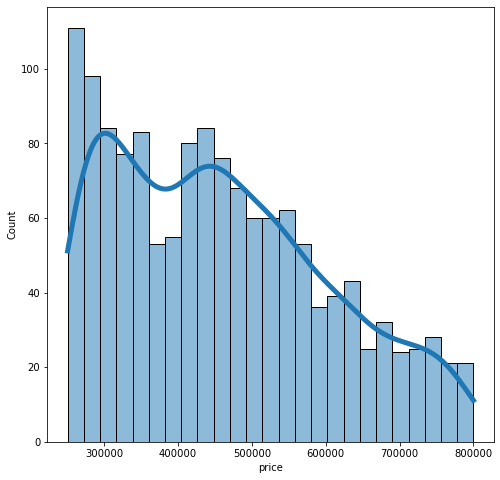

In [74]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

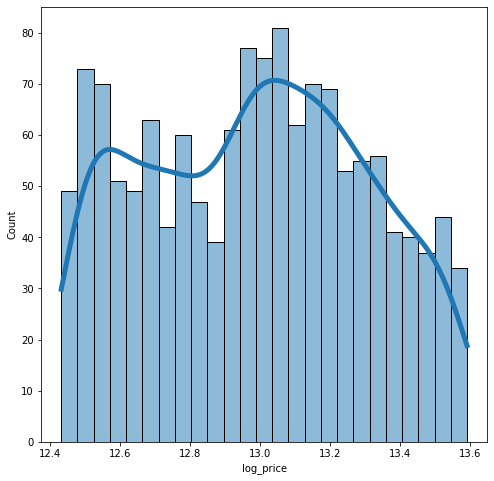

In [75]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

In [76]:
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,salesyear,sls_month,log_price
count,"1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398","1,398"
mean,"4,928,521,486","458,139",4,2,"2,247","8,046",1,0,0,3,8,"1,524",723,"1,984","1,984","98,063",48,-122,"2,031","8,260",36,"2,014",7,13
std,"2,851,332,214","144,653",1,1,632,"1,858",0,0,1,1,1,491,298,11,11,50,0,0,476,"2,493",11,0,3,0
min,"11,300,120","250,600",1,1,"1,090","4,000",1,0,0,2,6,590,0,"1,971","1,971","98,001",47,-122,930,"1,499",5,"2,014",1,12
25%,"2,473,410,788","330,000",3,2,"1,790","7,030",1,0,0,3,7,"1,217",500,"1,977","1,977","98,030",47,-122,"1,720","7,225",31,"2,014",4,13
50%,"4,099,550,150","440,000",4,2,"2,120","7,925",1,0,0,3,8,"1,390",690,"1,979","1,979","98,052",48,-122,"1,960","8,008",41,"2,014",6,13
75%,"7,691,900,202","556,875",4,3,"2,530","9,517",1,0,0,4,8,"1,670",900,"1,989","1,989","98,092",48,-122,"2,270","9,534",43,"2,015",9,13
max,"9,839,300,775","799,950",8,5,"5,110","12,000",3,1,4,5,10,"3,850","2,170","2,015","2,015","98,199",48,-121,"4,410","47,462",49,"2,015",12,14


##    B. Scaling, Converting & Eliminating Multicolinearity

In [77]:
model1_Continuous_variables  = ['bedrooms', 'bathrooms','sqft_lot', 'floors', 
                                                  'sqft_above', 'sqft_basement', 'sqft_living15', 'AgeOfHome']

data_Target_Homes_Continuous = data_Target_Homes[model1_Continuous_variables]
# model1_Continuous_variables = data_Target_Homes_Continuous.columns

In [78]:
#Scale Continuous initial data
scaled_df_no_index, scaler_1 = scaleData_min_max (data_Target_Homes_Continuous)

In [83]:
pd.reset_option('display.float_format')
scaled_df_no_index.head()

,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,AgeOfHome
0,0.428571,0.5000,0.125000,0.5,0.426380,0.447005,0.347701,0.818182
1,0.428571,0.4375,0.332375,0.0,0.211656,0.359447,0.313218,0.772727
2,0.142857,0.1875,0.568750,0.0,0.122699,0.456221,0.158046,0.772727
3,0.285714,0.3125,0.250000,0.0,0.159509,0.253456,0.146552,0.818182
4,0.285714,0.5625,0.284750,0.5,0.426380,0.364055,0.278736,0.204545


In [85]:
# df = pd.DataFrame([[1,1.23,'Hello']], columns=list('ABC'))
df2 = pd.DataFrame([[4000]],columns=['sqft_lot'])
type(df2)

pandas.core.frame.DataFrame

In [86]:
value = scaler_1.transform(df2)
value

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,8)

Convert Categorical To Dummy

In [ ]:
# categoricals = ['waterfront', 'view', 'condition', 'grade']
# dummies = pd.get_dummies(data_with_Ap_Hot_Dist_POints[categoricals], prefix=categoricals, drop_first=True)

dummies_3digitZip = pd.get_dummies(data_Target_Homes['ZipFirst3'], prefix='ZipFirst3', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('ZipFirst3', axis=1)

dummies_water = pd.get_dummies(data_Target_Homes['waterfront'], prefix='waterfront', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('waterfront', axis=1)

dummies_view = pd.get_dummies(data_Target_Homes['view'], prefix='view', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('view', axis=1)

dummies_condition = pd.get_dummies(data_Target_Homes['condition'], prefix='condition', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('condition', axis=1)

dummies_grade = pd.get_dummies(data_Target_Homes['grade'], prefix='grade', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('grade', axis=1)

dummies_salesMnth = pd.get_dummies(data_Target_Homes['sls_month'], prefix='sls_mnth' ,drop_first=True)
data_Target_Homes = data_Target_Homes.drop('sls_month', axis=1)




data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes, dummies_water], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_3digitZip], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_view], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_condition], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_grade], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_salesMnth], axis=1)

data_Target_Homes_Not_Scaled_WithDummies.rename(columns={'waterfront_1.0': 'waterfront_1', 'view_1.0': 'view_1',
                'view_1.0':'view_1', 'view_2.0':'view_2', 'view_3.0':'view_3', 'view_4.0':'view_4'}, inplace=True)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Not_Scaled_WithDummies.drop(['bedrooms', 'bathrooms',
                                                                                      'sqft_living',
                                                                                      'sqft_lot', 'floors', 
                                                                                      'sqft_above', 
                                                                                      'sqft_basement',
                                                                                      'sqft_living15', 
                                                                                      'sqft_lot15',
                                                                                      'AgeOfHome'],
                                                                                     axis = 1)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies.reset_index(drop=True)
data_Target_Homes_Scaled_WithDummies = pd.concat([data_Target_Homes_Scaled_WithDummies, scaled_df_no_index], axis=1)

In [ ]:
data_Target_Homes_Scaled_WithDummies.describe()

In [ ]:
model1_Constantants = ['id,','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']

model1_Categorical_variables = ['waterfront_1', 'view_1', 
                                'view_2', 'view_3', 'view_4', 
                                'condition_2', 'condition_3','condition_4', 'condition_5', 'grade_5','grade_6',
                                'grade_7','grade_8', 'grade_9', 'grade_10','grade_11', 'ZipFirst3_981',
                               "sls_mnth_2","sls_mnth_3","sls_mnth_4","sls_mnth_5","sls_mnth_6","sls_mnth_7",
                               "sls_mnth_8","sls_mnth_9", "sls_mnth_10","sls_mnth_11","sls_mnth_12"]

Next Find Correlation and Mulicolinearity

In [ ]:
model1_Categorical_variables_to_remove = ['grade_5','grade_6','condition_3', 'condition_2', 'grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

In [ ]:
model1_Categorical_variables_to_remove = ['grade_7']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['floors', "AgeOfHome"]
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

In [ ]:
vifResults = checkForVIF(data_Review_Colinearity_Model1)
vifResults

In [ ]:
# Create new variables Rooms and sqft_Above_Combo given high vifs
data_Review_Colinearity_Model1["ttl_Rooms"] = data_Review_Colinearity_Model1['bedrooms']*data_Review_Colinearity_Model1['bathrooms']
data_Review_Colinearity_Model1["sqft_Above_Combo"] = data_Review_Colinearity_Model1['sqft_above']*data_Review_Colinearity_Model1['sqft_living15']

#drop variable that were associated with interaction above
data_Review_Colinearity_Model1 = data_Review_Colinearity_Model1.drop(['bedrooms','bathrooms', 'sqft_living15', 'sqft_above'], axis=1)
checkForVIF(data_Review_Colinearity_Model1)

In [ ]:
correlation_heatmap(data_Review_Colinearity_Model1)

In [ ]:
#Remove Columns from our list of continuous and Categorical values indentified in VIF and Colinear testing

model1_Categorical_variables_to_remove = ['NA']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['sqft_above','sqft_living15','bathrooms','bedrooms']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

#Add newly created features to model
data_Target_Homes_Scaled_WithDummies["ttl_Rooms"] = data_Review_Colinearity_Model1["ttl_Rooms"]
model1_Continuous_variables.append("ttl_Rooms")
data_Target_Homes_Scaled_WithDummies["sqft_Above_Combo"] = data_Review_Colinearity_Model1["sqft_Above_Combo"]
model1_Continuous_variables.append("sqft_Above_Combo")

##    C. Create Pickle of Dataset

Get All needed fields ready for Pickle file

In [ ]:
FieldsMovingForward = ['id', 'price','log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model1.columns)
data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies[FieldsMovingForward]

Create Pickle File for testing Initial Model

In [ ]:
with open('regression_Data_Initial_Model.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Scaled_WithDummies, f)

with open('regression_Data_xref.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Not_Scaled_WithDummies, f)

In [ ]:
pd.reset_option('display.float_format')
data_Target_Homes_Scaled_WithDummies.describe()

# <u><font color='red'>Model 2 Dataset</font></u>

##    A. Adding Features - Location Based

Add additional Location Based features - Zip HotnessScores (HotnessScore), Count of Attractions with 7 miles of home(#1,#2,#3 attractions), School district for home and its rank (SchoolDistRank)

In [ ]:
# Get Data From Above - Build Upon Model 1
with open('regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [ ]:
#get Hotness Scores
df_Hotness_Zone = pd.read_excel("./data/ZIP_cube_HotnessZones.xlsx")
data_with_Hot = data_Model2.merge(df_Hotness_Zone[["zipcode","HotnessScore"]], on="zipcode", how="left")

#get School District & Rank
df_School_District_Info = pd.read_excel('./data/df_SchoolDistricts_SchoolDigger - all.xlsx', sheet_name='Export')
df_School_District_Ranking = pd.read_excel('./data/SchoolDisctrictRank.xlsx', sheet_name='Export')
df_School_Districts_withRank = df_School_District_Info.merge(df_School_District_Ranking, on="School District")
data_with_Hot_Dist = data_with_Hot.merge(df_School_Districts_withRank[["id","SchoolDistRankBin"]], on="id")
# data_with_Hot_Dist.rename(columns={"State Rank": "SchoolDistRank"})

#get points of interest within 7 miles
df_Points_Of_Interest = pd.read_excel('./data/df_points_of_int_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist.merge(df_Points_Of_Interest, on="id")
data_with_Hot_Dist_POints.rename(columns={1: "#1Attractions", 2: "#2Attractions", 3: "#3Attractions"}, inplace=True)

#get points of interest within 7 miles
df_Proximity_To_FortuneFives = pd.read_excel('./data/df_Counts_of_Fortune500_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.merge(df_Proximity_To_FortuneFives, on="id")


# fill in attraction columns 
data_with_Hot_Dist_POints['#1Attractions'].fillna(0, inplace=True)
data_with_Hot_Dist_POints['#2Attractions'].fillna(0, inplace=True)

data_with_Hot_Dist_POints.rename(columns={'#1Attractions':'Attractions1', '#2Attractions':'Attractions2', '#3Attractions':'Attractions3',
                                          'HotnessScore':'ZipHotnessScore'}, inplace=True)

data_with_Hot_Dist_POints.fillna(0, inplace=True)

In [ ]:
data_with_Hot_Dist_POints.head()

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [ ]:
model2_Continuous_variables  = ['ZipHotnessScore','Attractions1', 'Attractions2', 'Attractions3',
                               'FFives_Under10', 'FFives_Over10', 'FFives_Over20']

model2_Categorical_variables  = ['Sch_d_Top15','Sch_d_Top30', 'Sch_d_Top60']


data_with_Hot_Dist_POints_Continuous = data_with_Hot_Dist_POints[model2_Continuous_variables]

In [ ]:
#Scale Continuous initial data
scaled_df_no_index2 = scaleData_min_max (data_with_Hot_Dist_POints_Continuous)

In [ ]:
#create dummies for new categorical
dummies_SchoolRankBins = pd.get_dummies(data_with_Hot_Dist_POints['SchoolDistRankBin'], prefix='Sch_d', drop_first=True)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.drop('SchoolDistRankBin', axis=1)

#Add dummies back to main DF
data_with_Hot_Dist_POints_WithDummies = pd.concat([data_with_Hot_Dist_POints, dummies_SchoolRankBins], axis=1)

#drop original features that got scaled above
data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.drop(model2_Continuous_variables, axis=1)

data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.reset_index(drop=True)

#bring newly scaled and dummies together
data_with_Hot_Dist_POints = pd.concat([data_with_Hot_Dist_POints_WithDummies, scaled_df_no_index2], axis=1)

In [ ]:
data_with_Hot_Dist_POints.head()

Check For Colinearity - feed all relevant categorical and dummy variables into colinearity review

In [ ]:
model2_Categorical_variables_to_remove = ['NA']
# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['NA']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

In [ ]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

Drop 

In [ ]:
model1_Categorical_variables_to_remove = ['ZipFirst3_981']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['AgeOfHome']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables_to_remove = ['NA']
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['Attractions2','Attractions3', 'Attractions1','ZipHotnessScore']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

In [ ]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

In [ ]:
correlation_heatmap(data_Review_Colinearity_Model2)

##     C. Create Pickle of Dataset

In [ ]:
FieldsMovingForward = ['id', 'log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model2.columns)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints[FieldsMovingForward]

In [ ]:
import pickle
# Save
with open('regression_Data_Second_Model.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints, f)

# <u> <font color='red'>Model 3 Dataset</font> </u>

## A. Adding Features - Previous Year Assesor Values

Add additional previous yr county assessor valuation - AppraisedLandValue, AppraisedImpsValue(aka house value), LandToHouseCheck, InflationSinceLastAppraisal

In [ ]:
# Get Data From Above - Build Upon Model 2

# Load Data From Pickel
with open('regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [ ]:
data_Model3['salesyear'] = pd.DatetimeIndex(data_Model3['date']).year
data_Model3['yearpriortosale'] = data_Model3['salesyear'] - 1
data_Model3["yearpriortosale_str"] = data_Model3["yearpriortosale"].astype('str')
data_Model3["id_str"] = data_Model3["id"].astype('str')
data_Model3['appraisalKey'] = data_Model3['id_str'] + data_Model3['yearpriortosale_str']

#get Appraisal Data - inner join to eleminate valus with no appraisals
df_Appraisal_Info = pd.read_excel('./data/Appraisals_Values_Table_w_3yrRolling.xlsx')
df_Appraisal_Info["appraisalKey"] = df_Appraisal_Info["appraisalKey"].astype('str')
df_data_with_Appraisals = data_Model3.merge(df_Appraisal_Info[['YrRollingAppraisal','AppraisedLandValue','AppraisedImpsValue','LandToHouseCheck','InflationSinceLastAppraisal','InflationSinceLastAppraisal_abs','appraisalKey']], on="appraisalKey", how="inner")

df_data_with_Appraisals.drop(['appraisalKey', 'id_str', 'salesyear', 'yearpriortosale_str', 'yearpriortosale'], axis=1, inplace=True)

In [ ]:
#Remove addtiaional outliers, "abnarmally" expensive, big, etc. homes 
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['LandToHouseCheck'] <= .6]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['InflationSinceLastAppraisal_abs'] <= .15]

In [ ]:
df_data_with_Appraisals.describe()

In [ ]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=df_data_with_Appraisals,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [ ]:
model3_Continuous_variables  = ['YrRollingAppraisal','AppraisedLandValue', 
                                  'AppraisedImpsValue', 'LandToHouseCheck',
                                  'InflationSinceLastAppraisal', 
                                  'InflationSinceLastAppraisal_abs']


data_with_Appraisals_Continuous = df_data_with_Appraisals[model3_Continuous_variables]

In [ ]:
# Scale new continuous variables
scaled_df_no_index3 = scaleData_min_max (data_with_Appraisals_Continuous)

In [ ]:
df_data_with_Appraisals = df_data_with_Appraisals.drop(model3_Continuous_variables, axis=1)
df_data_with_Appraisals = df_data_with_Appraisals.reset_index(drop=True)
df_data_with_Appraisals = pd.concat([df_data_with_Appraisals, scaled_df_no_index3], axis=1)

In [ ]:
df_data_with_Appraisals.head()

Check For Colinearity

In [ ]:
model1_Categorical_variables

In [ ]:
# model3_Categorical_variables_to_remove = ['NA']
# model3_Categorical_variables = model2_Categorical_variables
# model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['NA']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

In [ ]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

In [ ]:
model1_Categorical_variables_to_remove = ['waterfront_1']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove_v1 = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove_v1)]

# model3_Categorical_variables_to_remove = ['NA']
# model3_Categorical_variables = model2_Categorical_variables
# model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['YrRollingAppraisal','InflationSinceLastAppraisal_abs','LandToHouseCheck',
                                         'InflationSinceLastAppraisal']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Categorical_variables + model1_Continuous_variables 

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

In [ ]:
data_Review_Colinearity_Model3["AssesorAppraisals"] = data_Review_Colinearity_Model3['AppraisedLandValue']*data_Review_Colinearity_Model3['AppraisedImpsValue']
data_Review_Colinearity_Model3 = data_Review_Colinearity_Model3.drop(['AppraisedLandValue','AppraisedImpsValue'], axis=1)
df_data_with_Appraisals["AssesorAppraisals"] = data_Review_Colinearity_Model3["AssesorAppraisals"]

In [ ]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

In [ ]:
data_Review_Colinearity_Model3.describe()

In [ ]:
correlation_heatmap(data_Review_Colinearity_Model3)

## C. Create Pickle of Dataset

In [ ]:
FieldsMovingForward = ['id', 'log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model3.columns)
df_data_with_Appraisals = df_data_with_Appraisals[FieldsMovingForward]

In [ ]:
import pickle
# Save
with open('regression_Data_Third_Model.pickle', 'wb') as f:
    pickle.dump(df_data_with_Appraisals, f)

In [ ]:
scaler_

# Ensure linearity of features(independent) to target(dependent)

In [ ]:
data_No_Outliers["price"].describe().apply("${0:,.0f}".format)
#"Average" - middle class houses between 367k& 638$k

In [ ]:
data_pred = data_No_Outliers[['YrRollingAppraisal','AppraisedLandValue', 'AppraisedImpsValue', 'LandToHouseCheck',
       'InflationSinceLastAppraisal','bedrooms', 'bathrooms', 'sqft_living',
                                          'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
                                          'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15','YearsSinceRenovation', 'AgeOfHome', 
                                          'price', 'HotnessScore', 'State Rank','#1Attractions', 
                                          '#2Attractions', '#3Attractions']]

plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)

for index, column in enumerate(data_pred):

    if column != "price":
        ax = plt.subplot(6, 5, index+1)
        sns.regplot(x=column, y="price", data=data_No_Outliers, ax=ax, label='medium', line_kws={"color": "red"});
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
    
plt.show();
